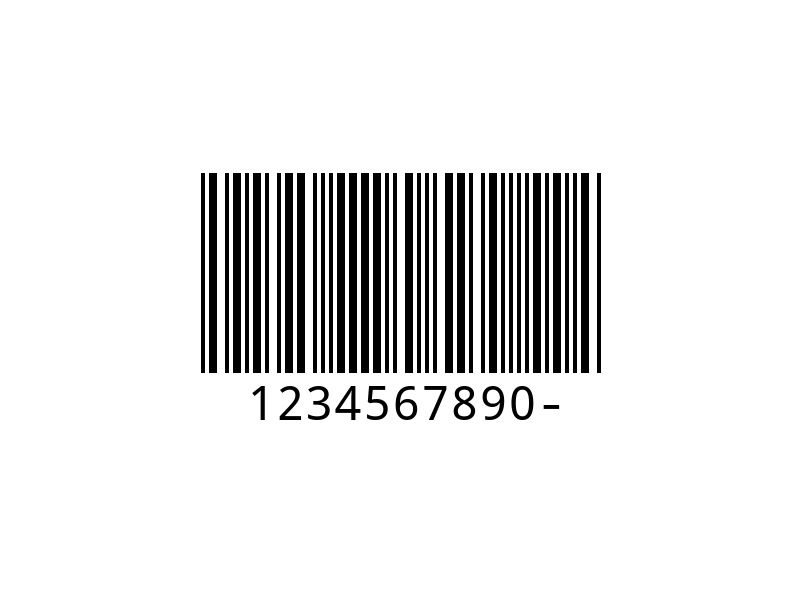

Detected Contrast Range: 255
Obstruction detected (dynamic thresholding).
Fixing obstruction...


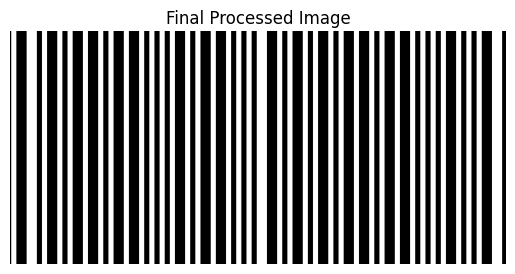

In [157]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from itertools import groupby
import math




#-------------------------------------------------------------------------------

# Function to detect if the image has low contrast
def detect_low_contrast(image, threshold=50):
    """Check if the image has low contrast based on histogram analysis."""
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist_range = np.where(hist > 0)[0]  # Find non-zero histogram bins

    if len(hist_range) == 0:
        return False  # Empty image case
    contrast = hist_range[-1] - hist_range[0]
    print(f"Detected Contrast Range: {contrast}")
    return contrast < threshold
#-------------------------------------------------------------------------------

# Function to fix low contrast using adaptive thresholding
def fix_low_contrast(image):
    """Fix low contrast using adaptive thresholding."""
    print("Fixing low contrast...")
    img_thresholded = cv2.adaptiveThreshold(
        image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 111, 1
    )
    return img_thresholded
#-------------------------------------------------------------------------------

# Function to detect obstruction in the image
def detect_obstruction(image):
    _, thresholded_img = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    obstruction_mask = thresholded_img == 255
    if np.any(obstruction_mask):
        print("Obstruction detected (dynamic thresholding).")
        return True

    print("No obstruction detected.")
    return False
#-------------------------------------------------------------------------------

# Function to fix obstruction
def fix_obstruction(image, kernel_size=(150, 1)):
    print("Fixing obstruction...")
    _, thresholded_img = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones(kernel_size, np.uint8)
    # to fix the finger problem i need to open first the thersholded image then close it
    closed_image = cv2.morphologyEx(thresholded_img, cv2.MORPH_CLOSE, kernel)
    return closed_image
#-------------------------------------------------------------------------------

# Function to crop the image to the barcode region
def cropped_image(image):
  # Use Canny edge detection
    edges = cv2.Canny(image, 50, 150)
    # Detect vertical lines using Hough Line Transform
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=150, maxLineGap=10)
    min_x, max_x, min_y, max_y = float('inf'), -float('inf'), float('inf'), -float('inf')

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # Vertical lines: x1 == x2 or nearly vertical
            if abs(x1 - x2) < 10:
                min_x = min(min_x, x1, x2)
                max_x = max(max_x, x1, x2)
                min_y = min(min_y, y1, y2)
                max_y = max(max_y, y1, y2)
            elif abs(y1 - y2) < 10:  # Horizontal lines
                min_x = min(min_x, x1, x2)
                max_x = max(max_x, x1, x2)
                min_y = min(min_y, y1, y2)
                max_y = max(max_y, y1, y2)

    if min_x != float('inf') and max_x != -float('inf') and min_y != float('inf') and max_y != -float('inf'):
        return image[min_y:max_y, min_x:max_x]
# cropped_image = cropped_image(np_binary_image)
# plt.imshow(cropped_image)
#-------------------------------------------------------------------------------
# import math
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt

# # Function to calculate the angle from the slope
# def check_angle(slope):
#     if slope == float('inf'):  # Vertical line
#         return 90  # 90 degrees for vertical lines
#     # Calculate angle in radians and convert to degrees
#     angle_rad = math.atan(slope)
#     angle_deg = math.degrees(angle_rad)
#     return angle_deg

# # Function to calculate the slope of a line
# def calculate_slope(x1, y1, x2, y2):
#     if x2 - x1 != 0:
#         return (y2 - y1) / (x2 - x1)  # Slope formula
#     else:
#         return float('inf')  # Infinite slope (vertical line)

# # Function to rotate the image by a given angle
# def rotate_image(img, angle):
#     (h, w) = img.shape[:2]
#     center = (w // 2, h // 2)  # Image center
#     rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
#     rotated_image = cv2.warpAffine(img, rotation_matrix, (w, h), borderValue=(255, 255, 255))
#     if lines is not None:
#       for line in lines:
#         x1, y1, x2, y2 = line[0]
#         slope = calculate_slope(x1, y1, x2, y2)
#         break  # Use the first detected line

#     # Calculate the angle from the slope
#     angle = check_angle(slope)
#     print(f"Detected angle: {angle}")
#     return rotated_image

# def apply_opening(image, kernel_size=(5, 5)):
#     kernel = np.ones(kernel_size, np.uint8)
#     opened_image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
#     return opened_image


# #-------------------------------------------------------------------------------
# # Main processing pipeline
# # def process_image():

# #     # Convert to Grayscale
# #     img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# #     plt.imshow(img_gray, cmap='gray')
# #     plt.title("Grayscale Image")
# #     plt.axis('off')
# #     plt.show()

# #     # Step 2: Detect the problem in the image
# #     is_low_contrast = detect_low_contrast(img_gray)
# #     is_obstructed = detect_obstruction(img_gray)

# #     # Step 3: Fix detected problems
# #     if is_obstructed:
# #         print("Problem Detected: Obstruction")
# #         fixed_img = fix_obstruction(img_gray)
# #     elif is_low_contrast:
# #         print("Problem Detected: Low Contrast")
# #         fixed_img = fix_low_contrast(img_gray)
# #     else:
# #         print("No Major Problem Detected, Proceeding with Original Image")
# #         fixed_img = img_gray

# #     # Step 4: Crop the image to focus on the barcode region
# #     cropped_barcode = cropped_image(fixed_img)

# #     # Step 5: Display Results
# #     plt.imshow(cropped_barcode, cmap='gray')
# #     plt.title("Processed Barcode")
# #     plt.axis('off')
# #     plt.show()
# # # Run the pipeline
# # process_image()
# #-------------------------------------------------------------------------------
# # # img, filename = load_image()
# img = cv2.imread("/content/09 - e3del el soora ya3ammm.jpg")
# # Convert the image to grayscale
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# # Apply Canny edge detection
# edges = cv2.Canny(gray, 50, 150)
# # Use Hough Line Transform to detect lines
# lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=150, maxLineGap=10)

# if (check_angle(slope) != 90):
#     rotated_image = rotate_image(img, angle - 90)
#     print("Image rotated.")
#     # Convert the rotated image to binary
#     gray_rotated = cv2.cvtColor(rotated_image, cv2.COLOR_BGR2GRAY)
#     _, binary_image = cv2.threshold(gray_rotated, 127, 255, cv2.THRESH_BINARY)
#     np_binary_image = np.array(binary_image)
#     cropped_image = cropped_image(np_binary_image)
#     kernel_size = (150, 1)
#     opened_image = apply_opening(cropped_image, kernel_size)
#     # Display the opened image
#     plt.imshow(opened_image, cmap='gray')
#     plt.axis('off')
#     plt.show()
# # else:
# #     process_image()


import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# Global image variable
img = cv2.imread("/content/01 - lol easy.jpg")
cv2_imshow(img)


# Function to calculate the angle from the slope
def check_angle(slope):
    if slope == float('inf'):  # Vertical line
        return 90  # 90 degrees for vertical lines
    angle_rad = math.atan(slope)
    angle_deg = math.degrees(angle_rad)
    return angle_deg

# Function to calculate the slope of a line
def calculate_slope(x1, y1, x2, y2):
    if x2 - x1 != 0:
        return (y2 - y1) / (x2 - x1)  # Slope formula
    else:
        return float('inf')  # Infinite slope (vertical line)

# Function to rotate the image by a given angle
def rotate_image(angle):
    global img
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)  # Image center
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(img, rotation_matrix, (w, h), borderValue=(255, 255, 255))
    return rotated_image

# Function to detect if the image has low contrast
def detect_low_contrast(image, threshold=50):
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist_range = np.where(hist > 0)[0]  # Find non-zero histogram bins
    if len(hist_range) == 0:
        return False  # Empty image case
    contrast = hist_range[-1] - hist_range[0]
    print(f"Detected Contrast Range: {contrast}")
    return contrast < threshold

# Function to fix low contrast using adaptive thresholding
def fix_low_contrast(image):
    print("Fixing low contrast...")
    img_thresholded = cv2.adaptiveThreshold(
        image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 111, 1
    )
    return img_thresholded

# Function to detect obstruction in the image
def detect_obstruction(image):
    _, thresholded_img = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    obstruction_mask = thresholded_img == 255
    if np.any(obstruction_mask):
        print("Obstruction detected (dynamic thresholding).")
        return True
    print("No obstruction detected.")
    return False

# Function to fix obstruction
def fix_obstruction(image, kernel_size=(150, 1)):
    print("Fixing obstruction...")
    _, thresholded_img = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones(kernel_size, np.uint8)
    closed_image = cv2.morphologyEx(thresholded_img, cv2.MORPH_CLOSE, kernel)
    return closed_image

# Function to apply morphological opening
def apply_opening(image, kernel_size=(5, 5)):
    kernel = np.ones(kernel_size, np.uint8)
    opened_image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    return opened_image

# Main pipeline
def process_image():
    global img
    # Convert to Grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect the problem in the image
    is_low_contrast = detect_low_contrast(img_gray)
    is_obstructed = detect_obstruction(img_gray)

    # Fix detected problems
    if is_obstructed:
        fixed_img = fix_obstruction(img_gray)
    elif is_low_contrast:
        fixed_img = fix_low_contrast(img_gray)
    else:
        fixed_img = img_gray

    # Rotate the image if necessary
    edges = cv2.Canny(fixed_img, 50, 150)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=150, maxLineGap=10)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            slope = calculate_slope(x1, y1, x2, y2)
            angle = check_angle(slope)
            if angle != 90:
                fixed_img = rotate_image(angle - 90)
            break

    # Crop the image
    cropped_barcode = cropped_image(fixed_img)


    # Display results
    plt.imshow(opened_image, cmap='gray')
    plt.title("Final Processed Image")
    plt.axis('off')
    plt.show()

# Run the pipeline
process_image()
